# Face Detect

In [1]:
import time 
import urllib
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline 

_url = 'https://westus.api.cognitive.microsoft.com/face/v1.0/detect'
_key = 'Use sua chave da API aqui!'
_maxNumRetries = 10

## Helper function

Processa a requisição para a API

#### Parameters:
* json: Used when processing images from its URL. See API Documentation
* data: Used when processing image read from disk. See API Documentation
* headers: Used to pass the key information and the data type request

In [2]:
def processRequest( json, data, headers, params ):

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

### Função para exibir o resultado na imagem

Exibe o resultado marcando as faces reconhecidas e inserindo o genero na foto

In [3]:
def renderResultOnImage( result, img ):
    
    colorRec = (255,0,0)
    
    for currFace in result:
        if currFace['faceAttributes']['gender'] == 'male': 
            colorRec = (255,0,0) 
        else: 
            colorRec = (153,204,50)
        
        faceRectangle = currFace['faceRectangle']
        
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = colorRec, thickness = 5 )
        
        currEmotion = currFace['faceAttributes']['gender']

        textToWrite = "%s" % ( currEmotion )
        
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, colorRec, 2 )


In [4]:
#urlImage = 'https://meriatblob.blob.core.windows.net/demos/cognitive/detection.jpg'
urlImage = 'https://meriatblob.blob.core.windows.net/demos/cognitive/faces.jpeg'

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None
#params = None
params = urllib.parse.urlencode({
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'true',
    'returnFaceAttributes': 'age,gender,smile,facialHair,headPose,glasses',
})

result = processRequest( json, data, headers, params )

print(result)

[{'faceId': '5308a491-f2ad-4512-9a3f-8966f5e20127', 'faceAttributes': {'smile': 0.939, 'gender': 'female', 'glasses': 'NoGlasses', 'headPose': {'pitch': 0.0, 'yaw': -0.1, 'roll': -7.5}, 'facialHair': {'moustache': 0.0, 'beard': 0.0, 'sideburns': 0.0}, 'age': 29.4}, 'faceRectangle': {'left': 1400, 'width': 182, 'height': 182, 'top': 1192}, 'faceLandmarks': {'upperLipTop': {'y': 1309.2, 'x': 1494.5}, 'eyeLeftTop': {'y': 1244.1, 'x': 1447.0}, 'eyebrowLeftInner': {'y': 1222.8, 'x': 1465.8}, 'eyebrowRightOuter': {'y': 1212.6, 'x': 1547.4}, 'mouthLeft': {'y': 1333.0, 'x': 1464.4}, 'eyeLeftBottom': {'y': 1249.3, 'x': 1447.4}, 'noseRightAlarTop': {'y': 1267.2, 'x': 1504.7}, 'eyeRightOuter': {'y': 1237.2, 'x': 1536.3}, 'mouthRight': {'y': 1324.0, 'x': 1533.1}, 'noseLeftAlarTop': {'y': 1271.7, 'x': 1469.7}, 'eyeRightInner': {'y': 1241.4, 'x': 1512.0}, 'eyeRightBottom': {'y': 1242.0, 'x': 1525.3}, 'eyeRightTop': {'y': 1236.3, 'x': 1524.0}, 'eyebrowRightInner': {'y': 1216.9, 'x': 1504.3}, 'pupilRi

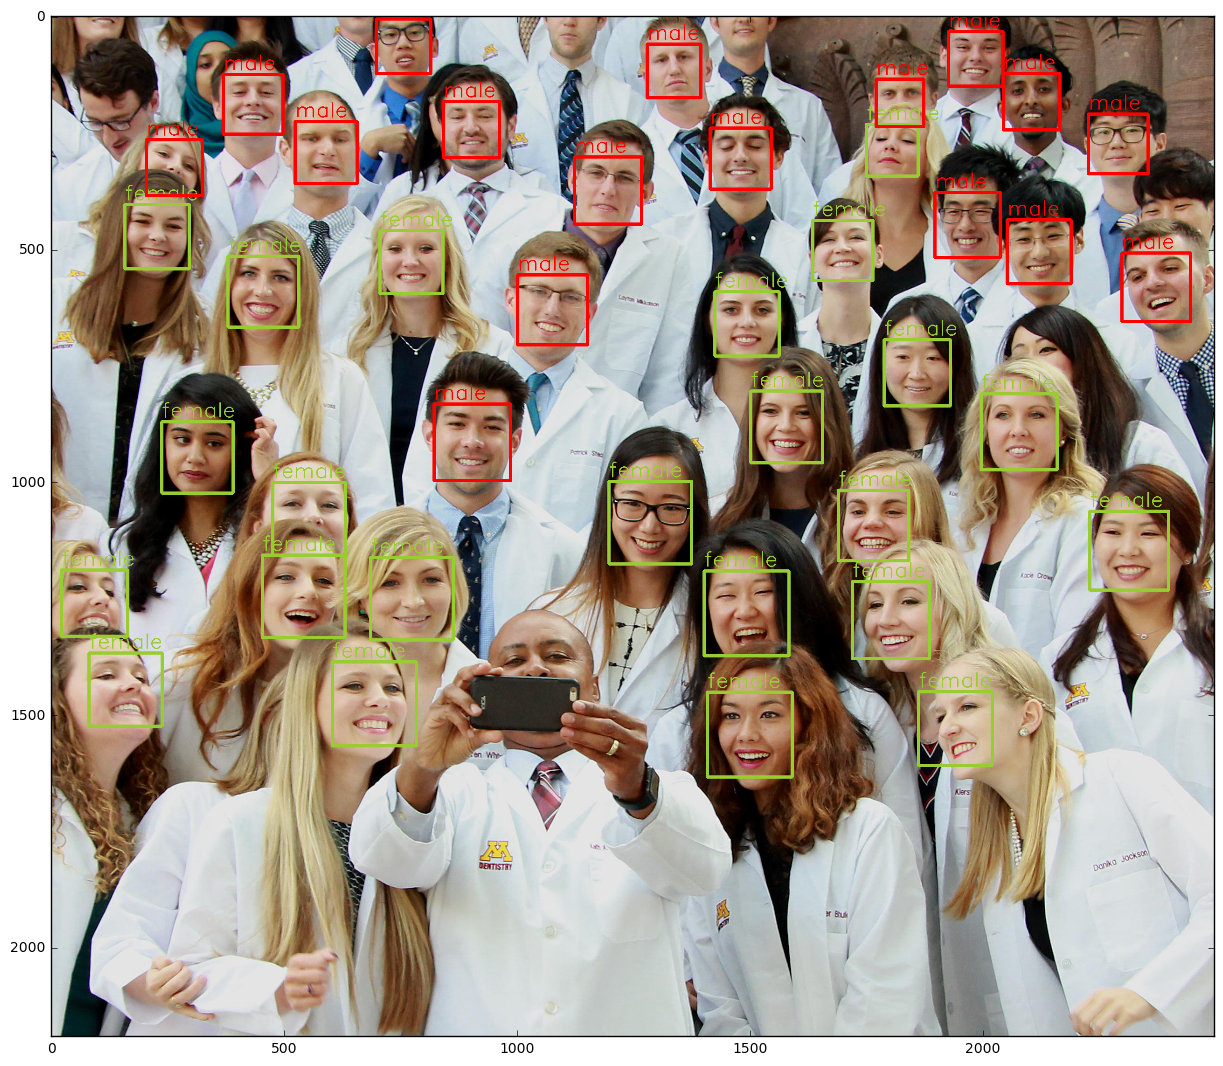

In [5]:
if result is not None:
    
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )